# Lake Victoria levels analysis : create interpolated lake level time series 1896-2022, part 1  

## Data sources: 
- DAHITI, 2022 March download
- WMO Hydromet 1948-1995/1996 (from Vanderkelen et al 2018)

## What this notebook does: 
- analysis of DAHITI and WMO timeseries 
- merge together the DH and HM timeseries 1949-2022
    - calculates average difference from overlapping dates
    - corrects HM to match DH
    - overwrites overlapping period with DH
    - interpolate to daily resolution

    
## Output: 
- lake level DH + HM (1948-2022) using DH 2022 data and overwriting DH on top of HM, raw (lakelevel_all_raw_DH22.txt and csv) and interpolated to daily resolution (lakelevel_all_intr_DH22.txt and csv)

Created: July 2021 
By: Rosa Pietroiusti
Updated: 13 April 2022 (new 2022 dahiti data), cleaned 2023 


In [3]:
# Import packages (geo_env)

import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Others
import pprint
import os , glob
from osgeo import gdal
import scipy as scipy
from scipy import stats
import sklearn 
import datetime
from datetime import datetime
from matplotlib.pyplot import cm

alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

## 1) DAHITI data

### From Dahiti database, downloaded March 2022

- *1992-09-27 to 2022-03-03*

In [4]:
# Read in data 

data_2022 = pd.read_csv('DAHITI_lakelevels_070322.csv') # downloaded March 2022

In [13]:
data_2022['date'] = pd.to_datetime(data_2022['date'])
data_2022

,date,water level,error
0,1992-09-27,1135.000,0.000
1,1992-10-07,1135.023,0.001
2,1992-10-17,1135.032,0.000
3,1992-10-27,1134.958,0.000
4,1992-11-06,1135.035,0.000
...,...,...,...
1053,2022-01-22,1136.143,0.001
1054,2022-02-01,1136.145,0.001
1055,2022-02-11,1136.199,0.001
1056,2022-02-21,1136.227,0.001


10.169347209082304
[(9.0, 88), (10.0, 946), (19.0, 2), (20.0, 18), (29.0, 1), (30.0, 1), (40.0, 1)]


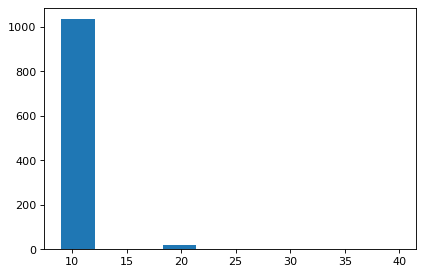

In [14]:
# Temporal resolution of DAHITI 2022 data 

dt = np.diff(data_2022['date'])
print(dt.mean() / np.timedelta64(1, "D"))

dt_hist = (dt / np.timedelta64(1, "D"))
dt_list = dt_hist.tolist()
plt.hist(dt_hist)

print(list(zip(*np.unique(dt_hist, return_counts=True))))

In [15]:
data_2022[['water level']].agg(['min', 'max', 'mean'])

,water level
min,1133.734000
max,1136.777000
mean,1135.111718


In [16]:
data_2022 = data_2022.set_index(['date'])
data_2022

,water level,error
date,,
1992-09-27,1135.000,0.000
1992-10-07,1135.023,0.001
1992-10-17,1135.032,0.000
1992-10-27,1134.958,0.000
1992-11-06,1135.035,0.000
...,...,...
2022-01-22,1136.143,0.001
2022-02-01,1136.145,0.001
2022-02-11,1136.199,0.001



### Merge together HYDROMET and DAHITI data  

In [36]:
# Read in data - This is new version with 2022 data

DAHITI = data_2022.copy()
DAHITI=DAHITI.rename(columns={"water level": "water_level"})
DAHITI


,water_level,error
date,,
1992-09-27,1135.000,0.000
1992-10-07,1135.023,0.001
1992-10-17,1135.032,0.000
1992-10-27,1134.958,0.000
1992-11-06,1135.035,0.000
...,...,...
2022-01-22,1136.143,0.001
2022-02-01,1136.145,0.001
2022-02-11,1136.199,0.001


In [37]:
HYDROMET_raw = pd.read_csv('Jinja_lakelevels_Van.txt', sep = "\t",  header = None)
HYDROMET_raw

,0,1,2,3,4
0,1948,1,1,1134.097,11.210
1,1948,1,2,1134.102,11.215
2,1948,1,3,1134.062,11.175
3,1948,1,4,1134.052,11.165
4,1948,1,5,1134.077,11.190
...,...,...,...,...,...
17741,1996,7,28,1134.777,11.890
17742,1996,7,29,1134.757,11.870
17743,1996,7,30,1134.752,11.865
17744,1996,7,31,1134.717,11.830


In [38]:
HYDROMET_raw.columns = ['year', 'month', 'day', 'water level', 'meas']
HYDROMET_dates = pd.to_datetime(HYDROMET_raw[['year', 'month', 'day']])
df = pd.DataFrame(HYDROMET_dates, columns = ['date'])
df[['water_level', 'meas']] = HYDROMET_raw[['water level', 'meas']]
HYDROMET = df.set_index(['date'])
HYDROMET

,water_level,meas
date,,
1948-01-01,1134.097,11.210
1948-01-02,1134.102,11.215
1948-01-03,1134.062,11.175
1948-01-04,1134.052,11.165
1948-01-05,1134.077,11.190
...,...,...
1996-07-28,1134.777,11.890
1996-07-29,1134.757,11.870
1996-07-30,1134.752,11.865


In [39]:
# Replace HYDROMET zeros with NaN, so that Matplotlib won't connect the points

HYDROMET.query('water_level == 0')

,water_level,meas
date,,
1977-01-01,0.0,0.0
1977-01-02,0.0,0.0
1977-01-03,0.0,0.0
1977-01-04,0.0,0.0
1977-01-05,0.0,0.0
...,...,...
1982-11-28,0.0,0.0
1982-11-29,0.0,0.0
1982-11-30,0.0,0.0


In [40]:
HYDROMET['water_level'] = HYDROMET['water_level'].replace(0, np.nan)
HYDROMET['meas'] = HYDROMET['meas'].replace(0, np.nan)
HYDROMET

,water_level,meas
date,,
1948-01-01,1134.097,11.210
1948-01-02,1134.102,11.215
1948-01-03,1134.062,11.175
1948-01-04,1134.052,11.165
1948-01-05,1134.077,11.190
...,...,...
1996-07-28,1134.777,11.890
1996-07-29,1134.757,11.870
1996-07-30,1134.752,11.865


In [41]:
HYDROMET.query('water_level != water_level')

,water_level,meas
date,,
1977-01-01,NaN,NaN
1977-01-02,NaN,NaN
1977-01-03,NaN,NaN
1977-01-04,NaN,NaN
1977-01-05,NaN,NaN
...,...,...
1982-11-28,NaN,NaN
1982-11-29,NaN,NaN
1982-11-30,NaN,NaN


In [42]:
# Get summary stats 

DAHITI[['water_level']].agg(['min', 'max', 'mean']) 

,water_level
min,1133.734000
max,1136.777000
mean,1135.111718


In [43]:
HYDROMET[['water_level']].agg(['min', 'max', 'mean']) 

,water_level
min,1133.447000
max,1136.277000
mean,1134.686917


range= 3.04300000000012 mtrim= 1135.072125 mean= 1135.1117183364838 p10= 1134.4847 p90= 1135.8463


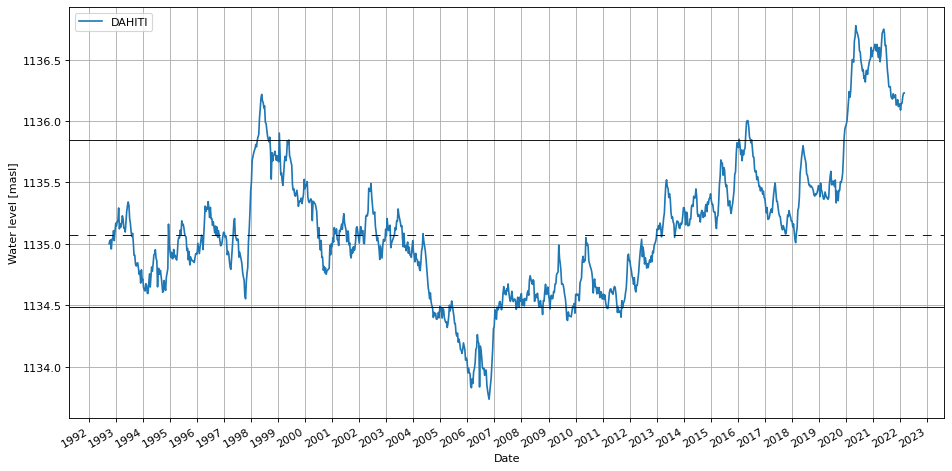

In [44]:
# Get mtrim for DAHITI and plot 

data = DAHITI
# range
max_level = data[['water_level']].max()
min_level = data[['water_level']].min()
range_level = max_level - min_level
# mtrim 
mtrim = stats.trim_mean(data[['water_level']], 0.1)
mtrim = mtrim.flatten().tolist()[0]
# 10th and 90th percentile
p10 = scipy.stats.scoreatpercentile(data[['water_level']], 10) # 10th percentile 
p90 = scipy.stats.scoreatpercentile(data[['water_level']], 90) # 90th percentile 

# print summary stats
print('range=',str(range_level[0]), 
      'mtrim=', str(mtrim), 'mean=', str(data[['water_level']].mean()[0]), 
      'p10=', str(p10), 'p90=',str(p90))

# plot 
fig, ax = plt.subplots(figsize=(12, 6))
DAHITI['water_level'].plot(ax=ax, label="DAHITI")
plt.axhline(mtrim, color='k', linewidth=0.8, linestyle='dashed', dashes=(10, 10))
plt.axhline(p10, color='k', linewidth=0.8)
plt.axhline(p90, color='k', linewidth=0.8)
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()


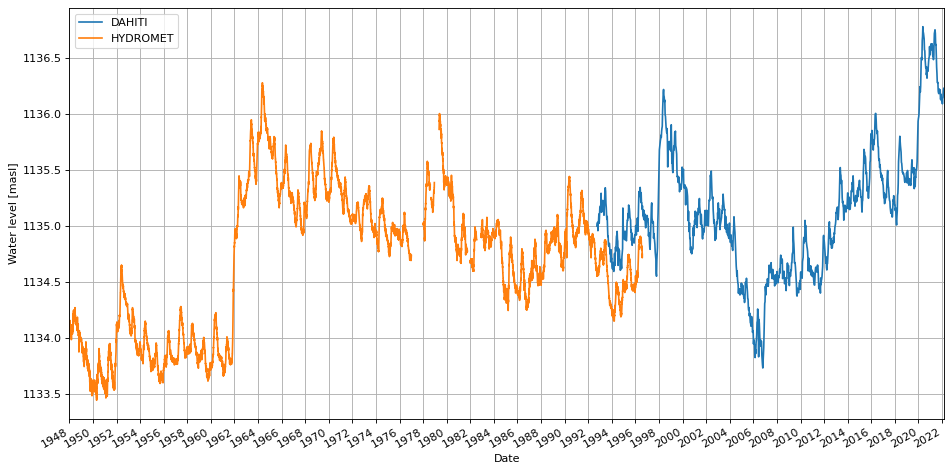

In [45]:
# Plot raw dahiti and hydromet

left = '1948-01-01'
right = '2022-03-03'


fig, ax = plt.subplots(figsize=(12, 6))
DAHITI['water_level'].plot(ax=ax, label="DAHITI")
HYDROMET['water_level'].plot(ax=ax, label="HYDROMET")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.set_xlim(left, right)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

plt.show()


### Snap the two time-series together

In [46]:
DAHITI

,water_level,error
date,,
1992-09-27,1135.000,0.000
1992-10-07,1135.023,0.001
1992-10-17,1135.032,0.000
1992-10-27,1134.958,0.000
1992-11-06,1135.035,0.000
...,...,...
2022-01-22,1136.143,0.001
2022-02-01,1136.145,0.001
2022-02-11,1136.199,0.001


In [47]:
HYDROMET

,water_level,meas
date,,
1948-01-01,1134.097,11.210
1948-01-02,1134.102,11.215
1948-01-03,1134.062,11.175
1948-01-04,1134.052,11.165
1948-01-05,1134.077,11.190
...,...,...
1996-07-28,1134.777,11.890
1996-07-29,1134.757,11.870
1996-07-30,1134.752,11.865


In [48]:
# Merge the two time-series, key on date, keep all observations (outer)
d_HYDROMET = HYDROMET.drop(['meas'], axis=1)
d_DAHITI = DAHITI.drop(['error'], axis=1)
df_merge = pd.merge(d_HYDROMET, d_DAHITI, how='outer', on='date')
df_merge.columns = ['HYDROMET', 'DAHITI']
df_merge # 18625 rows

# Get only the overlapping observations
df_overlap = df_merge.query('HYDROMET == HYDROMET & DAHITI == DAHITI')
df_overlap # 137 rows [1992-09-27 : 1996-07-26] 

,HYDROMET,DAHITI
date,,
1992-09-27,1134.567,1135.000
1992-10-07,1134.577,1135.023
1992-10-17,1134.567,1135.032
1992-10-27,1134.597,1134.958
1992-11-06,1134.582,1135.035
...,...,...
1996-06-17,1134.877,1135.214
1996-06-27,1134.872,1135.297
1996-07-07,1134.807,1135.204


In [49]:
avg_diff = (df_overlap['DAHITI'] - df_overlap['HYDROMET']).mean() # DAHITI overestimates vs. HYDROMET
n_diff = len(df_overlap)
std_diff = (df_overlap['DAHITI'] - df_overlap['HYDROMET']).std()
print('avg_diff =', avg_diff,  'n_diff =', n_diff, 'std_diff =', std_diff)
print('avg_diff_r =', round(avg_diff,3), 'std_diff_r =', round(std_diff,3) )

# 2022 data: Avg diff is 43.2 cm +/- 5.24 cm (one std)


avg_diff = 0.4319488746195349 n_diff = 137 std_diff = 0.05239589301085617
avg_diff_r = 0.432 std_diff_r = 0.052


In [50]:
HYDROMET

,water_level,meas
date,,
1948-01-01,1134.097,11.210
1948-01-02,1134.102,11.215
1948-01-03,1134.062,11.175
1948-01-04,1134.052,11.165
1948-01-05,1134.077,11.190
...,...,...
1996-07-28,1134.777,11.890
1996-07-29,1134.757,11.870
1996-07-30,1134.752,11.865


In [51]:
# Snap the two timeseries together, add avg diff to HYDROMET 

HYDROMET_corr = HYDROMET.copy()
HYDROMET_corr['water_level'] = HYDROMET['water_level'] + round(avg_diff,3)
HYDROMET_corr

,water_level,meas
date,,
1948-01-01,1134.529,11.210
1948-01-02,1134.534,11.215
1948-01-03,1134.494,11.175
1948-01-04,1134.484,11.165
1948-01-05,1134.509,11.190
...,...,...
1996-07-28,1135.209,11.890
1996-07-29,1135.189,11.870
1996-07-30,1135.184,11.865


In [52]:
DAHITI

,water_level,error
date,,
1992-09-27,1135.000,0.000
1992-10-07,1135.023,0.001
1992-10-17,1135.032,0.000
1992-10-27,1134.958,0.000
1992-11-06,1135.035,0.000
...,...,...
2022-01-22,1136.143,0.001
2022-02-01,1136.145,0.001
2022-02-11,1136.199,0.001


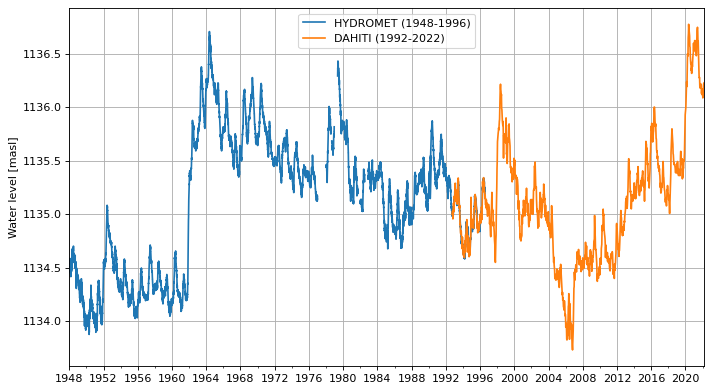

In [123]:
left = '1948-01-01'
right = '2022-03-03'


fig, ax = plt.subplots(figsize=(9, 5))
HYDROMET_corr['water_level'].plot(ax=ax, label="HYDROMET (1948-1996)")
DAHITI['water_level'].plot(ax=ax, label="DAHITI (1992-2022)")
ax.grid(True)
ax.legend(loc=9)
plt.xlabel("")
plt.ylabel("Water level [masl]")
ax.set_xlim(left, right)
ax.xaxis.set_major_locator(mdates.YearLocator(4))
ax.xaxis.set_minor_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

plt.show()


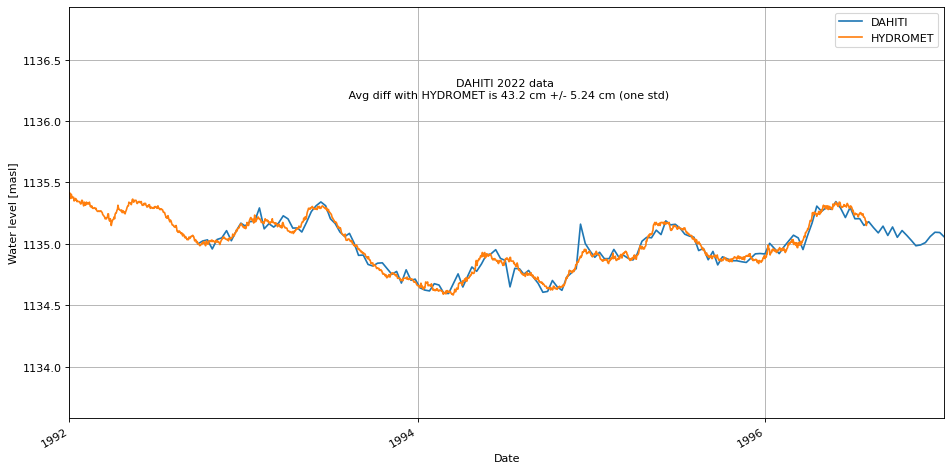

In [55]:
# 2022 data

left = '1992-01-01'
right = '1997-01-10'

fig, ax = plt.subplots(figsize=(12, 6))
DAHITI['water_level'].plot(ax=ax, label="DAHITI")
HYDROMET_corr['water_level'].plot(ax=ax, label="HYDROMET")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.text(0.5, 0.8, "DAHITI 2022 data \n Avg diff with HYDROMET is 43.2 cm +/- 5.24 cm (one std)",
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)
ax.set_xlim(left, right)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

#plt.show()
#plt.savefig(os.path.join(data_path,'DAHITI22_HYDROMET_overlap.png'))

In [57]:
# Hydromet has more than 3 sig figs, round to 3 sig figs 

# 1964 RECORD
# 1964-05-15, 1136.68 masl, 13.39 m in situ

HYDROMET_corr[HYDROMET_corr['water_level']==HYDROMET_corr['water_level'].max()].round(3)

,water_level,meas
date,,
1964-05-15,1136.709,13.39


In [58]:
print('HYDROMET max =',HYDROMET_corr['water_level'].max(), 'HYDROMET max in situ =',HYDROMET_corr['meas'].max() )
geoid_corr = HYDROMET_corr['water_level'].max() - HYDROMET_corr['meas'].max()
print('HYDROMET geoid corr =',geoid_corr)



HYDROMET max = 1136.70900034332 HYDROMET max in situ = 13.3900003433227
HYDROMET geoid corr = 1123.3189999999972


In [59]:
geoid = pd.DataFrame(HYDROMET_corr['water_level'] - HYDROMET_corr['meas'])
geoid.columns = ['geoidcorr']
geoid.geoidcorr.unique()

#str.format('{0:.15f}', geoid.geoidcorr.unique())

# The geoid correction seems pretty much constant 1123.319 meters added to the in situ measurement

array([1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319, 1123.319, 1123.319,
       1123.319, 1123.319, 1123.319, 1123.319,      nan])

In [60]:
# 2020 RECORD
# 2020-05-17, 1136.745 masl, 13.455 est in situ

DAHITI[DAHITI['water_level']==DAHITI['water_level'].max()]

,water_level,error
date,,
2020-05-17,1136.777,0.0


In [61]:
print('DAHITI max =', DAHITI['water_level'].max())
print('DAHITI max - HYDROMET max =', DAHITI['water_level'].max() - HYDROMET_corr['water_level'].max())
print('DAHITI est in situ =', DAHITI['water_level'].max() - geoid_corr)
print('DAHITI est in situ (round) =', DAHITI['water_level'].max() - round(geoid_corr,3))

DAHITI max = 1136.777
DAHITI max - HYDROMET max = 0.06799965668005825
DAHITI est in situ = 13.458000000002812
DAHITI est in situ (round) = 13.458000000000084


### Make a single time series from the 2 timeseries


In [62]:
startHYDROMET = np.datetime64('1948-01-01')
endHYDROMET = np.datetime64('1996-08-01')

startDAHITI = np.datetime64('1992-09-27')
endDAHITI = np.datetime64('2022-03-03') 

HYDROMET_keep = HYDROMET_corr.loc[ startHYDROMET : (startDAHITI - pd.Timedelta("1 day")) ]
HYDROMET_keep = HYDROMET_keep.drop(columns=['meas'])
HYDROMET_keep

# Overwriting time-series with DH where available

,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
1992-09-22,1135.034
1992-09-23,1135.024
1992-09-24,1135.009


In [63]:
DAHITI_keep = DAHITI.drop(columns=['error'])
DAHITI_keep

,water_level
date,
1992-09-27,1135.000
1992-10-07,1135.023
1992-10-17,1135.032
1992-10-27,1134.958
1992-11-06,1135.035
...,...
2022-01-22,1136.143
2022-02-01,1136.145
2022-02-11,1136.199


In [64]:
df_list = [HYDROMET_keep,DAHITI_keep]
lakelevels_all_raw = pd.concat(df_list, ignore_index=False)
pd.set_option("display.precision", 8)
lakelevels_all_raw

,water_level
date,
1948-01-01,1134.52900004
1948-01-02,1134.53400015
1948-01-03,1134.49400019
1948-01-04,1134.48399996
1948-01-05,1134.50899958
...,...
2022-01-22,1136.14300000
2022-02-01,1136.14500000
2022-02-11,1136.19900000


In [65]:
# Round to 3 sig figs 

lakelevels_all = lakelevels_all_raw.round(3)
pd.set_option("display.precision", 8)
lakelevels_all

# Merge of DAHITI and HYDROMET, with DAHITI overwriting HYDROMET from DAHITI start date (1992-09-27)
# Data gaps from HYDROMET
# Resolution decreases from DAHITI having lower res than HYD
# need to linearly interpolate missing data 


,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-01-22,1136.143
2022-02-01,1136.145
2022-02-11,1136.199


In [66]:
meanL = lakelevels_all['water_level'].mean()
maxL = lakelevels_all['water_level'].max()
minL = lakelevels_all['water_level'].min()
mtrim = stats.trim_mean(lakelevels_all[['water_level']], 0.1)
mtrim = mtrim.flatten().tolist()[0]
p10 = scipy.stats.scoreatpercentile(lakelevels_all[['water_level']], 10) # 10th percentile 
p90 = scipy.stats.scoreatpercentile(lakelevels_all[['water_level']], 90) # 90th percentile 

print('meanL =', meanL, 'maxL =', maxL, 'minL =', minL, 'range =', maxL-minL )
print('mtrim =', mtrim, 'p10 =', p10, 'p90 =', p90 )
print('start date =', left, 'enddate =', right)

#meanL = 1135.1319353655604 maxL = 1136.777 minL = 1133.734 range = 3.04300000000012
#mtrim = 1135.1791611953165 p10 = 1134.229 p90 = 1136.104


meanL = 1135.1319353655604 maxL = 1136.777 minL = 1133.734 range = 3.04300000000012
mtrim = 1135.1791611953165 p10 = 1134.229 p90 = 1136.104
start date = 1992-01-01 enddate = 1997-01-10


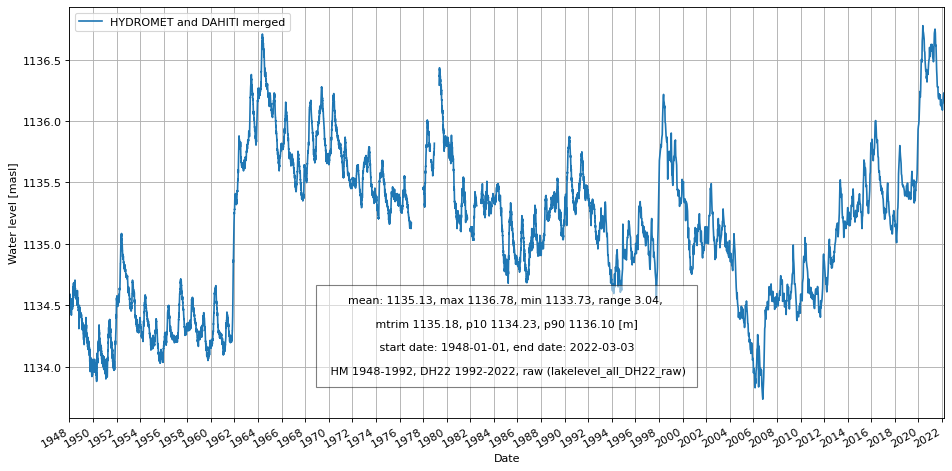

In [67]:
left = '1948-01-01'
right = '2022-03-03'


fig, ax = plt.subplots(figsize=(12, 6))
lakelevels_all['water_level'].plot(ax=ax, label="HYDROMET and DAHITI merged")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.set_xlim(left, right)
plot_text = ('mean: {:.2f}, max {:.2f}, min {:.2f}, range {:.2f}, \n \n mtrim {:.2f}, p10 {:.2f}, p90 {:.2f} [m] \n \n start date: {}, end date: {} \n \n HM 1948-1992, DH22 1992-2022, raw (lakelevel_all_DH22_raw)'
             .format(meanL, maxL, minL, maxL-minL, mtrim, p10,p90, left, right))  #, start date {:.3f}, end date {:.3f} 
#plot_text2 = "start date: %s, end date %s years old." %(left, right)
ax.text(0.5, 0.2, (plot_text), # , left, right
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()

plt.show()
#plt.savefig(os.path.join(data_path,'lakelevel_all_DH22_raw_annotate.png'))

# Merge of DAHITI and HYDROMET, with DAHITI overwriting HYDROMET from DAHITI start date (1992-09-27)
# Data gaps from HYDROMET
# Resolution decreases in overlap period from DAHITI having lower res than HYD

In [70]:
# Save lake levels merged, not interpolated

lakelevels_all
#lakelevels_all.to_csv(os.path.join('data_modified/lakelevel_all_raw_DH22.csv'),sep=',', index=True, header=True)

# Merged raw time-series not interpolated, DH overwrites HM from 1992. Time-series goes up to march 2022 (end of available data)




,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-01-22,1136.143
2022-02-01,1136.145
2022-02-11,1136.199


## interpolate to daily resolution

In [72]:
lakelevels_all

,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-01-22,1136.143
2022-02-01,1136.145
2022-02-11,1136.199


In [73]:
# Interpolate to daily res and round to 3 sig figs (number of DAHITI sig figs) - I lose the error measurements of Dahiti... 

lakelevels_intr = lakelevels_all.resample('D').asfreq().interpolate(method='linear').round(3)
lakelevels_intr

,water_level
date,
1948-01-01,1134.529
1948-01-02,1134.534
1948-01-03,1134.494
1948-01-04,1134.484
1948-01-05,1134.509
...,...
2022-02-27,1136.228
2022-02-28,1136.228
2022-03-01,1136.229


In [74]:
# Export as csv 

#lakelevels_intr.to_csv(os.path.join('data_modified/lakelevel_all_intr_DH22.csv'),sep=',', index=True, header=True)

# Merged time-series interpolated, DH overwrites HM from 1992. Time-series goes up to march 2022 (end of available data)



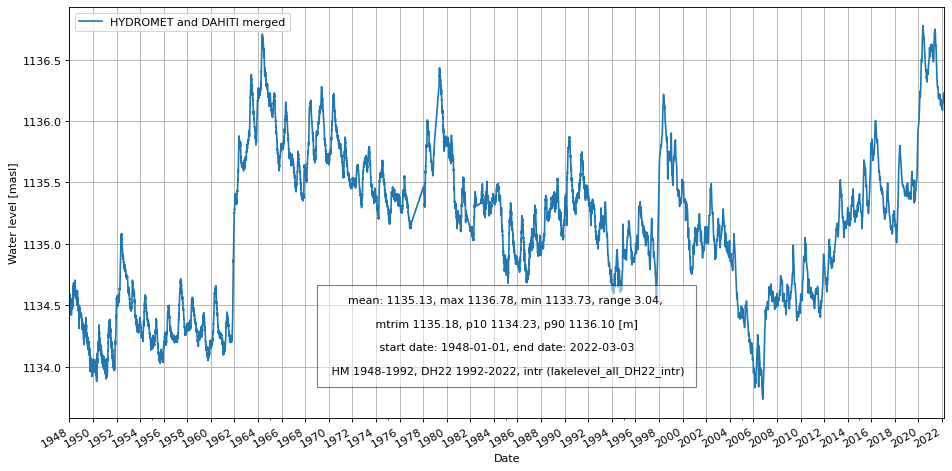

In [76]:
# Plot the interpolated lake levels 



left = '1948-01-01'
right = '2022-03-03'


fig, ax = plt.subplots(figsize=(12, 6))
lakelevels_intr['water_level'].plot(ax=ax, label="HYDROMET and DAHITI merged")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [masl]")
ax.set_xlim(left, right)
plot_text = ('mean: {:.2f}, max {:.2f}, min {:.2f}, range {:.2f}, \n \n mtrim {:.2f}, p10 {:.2f}, p90 {:.2f} [m] \n \n start date: {}, end date: {} \n \n HM 1948-1992, DH22 1992-2022, intr (lakelevel_all_DH22_intr)'
             .format(meanL, maxL, minL, maxL-minL, mtrim, p10,p90, left, right))  #, start date {:.3f}, end date {:.3f} 
ax.text(0.5, 0.2, (plot_text),
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()
fig.tight_layout()

plt.show()
#plt.savefig(os.path.join(data_path,'lakelevel_all_DH22_intr_annotate.png'))
